In [1]:
pip install pmdarima

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]
data_DMA225.shape

(2208, 10)

In [6]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ad6673f50>,
      dtype=object)

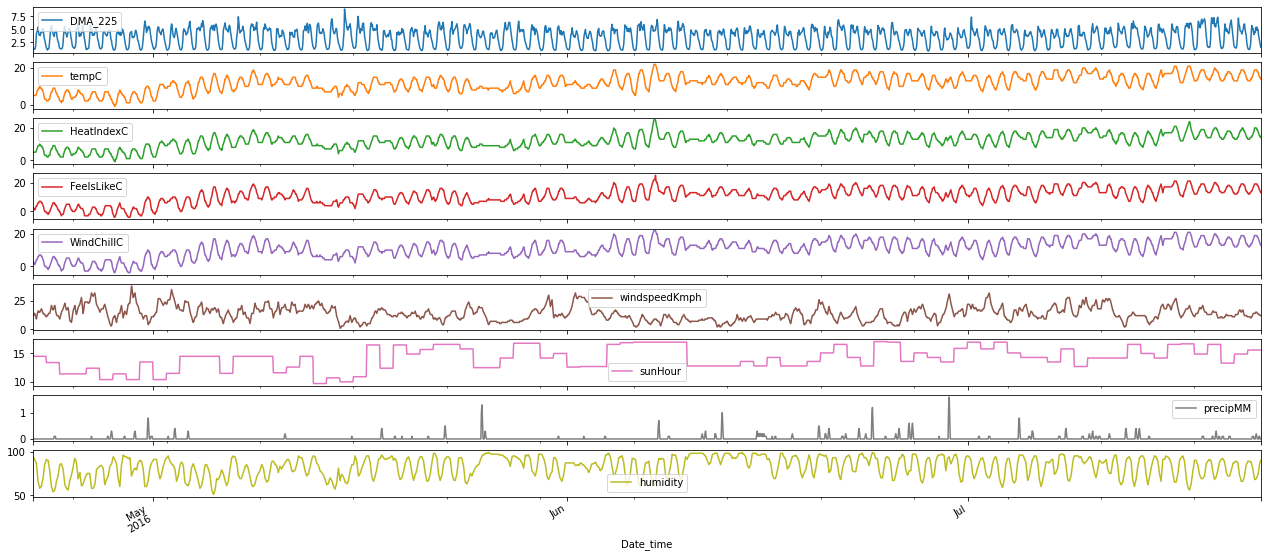

In [7]:
data_DMA225_indexed[['DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True,figsize=(22,10))


In [8]:

# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()
hourly_data.shape

(2208, 9)

In [9]:
hourly_data.head(2)

,DMA_225,tempC,HeatIndexC,FeelsLikeC,WindChillC,windspeedKmph,sunHour,precipMM,humidity
Date_time,,,,,,,,,
2016-04-22 00:00:00,1.13875,5,5,3,3,12,14.5,0.0,94
2016-04-22 01:00:00,1.16650,5,5,2,2,13,14.5,0.0,93


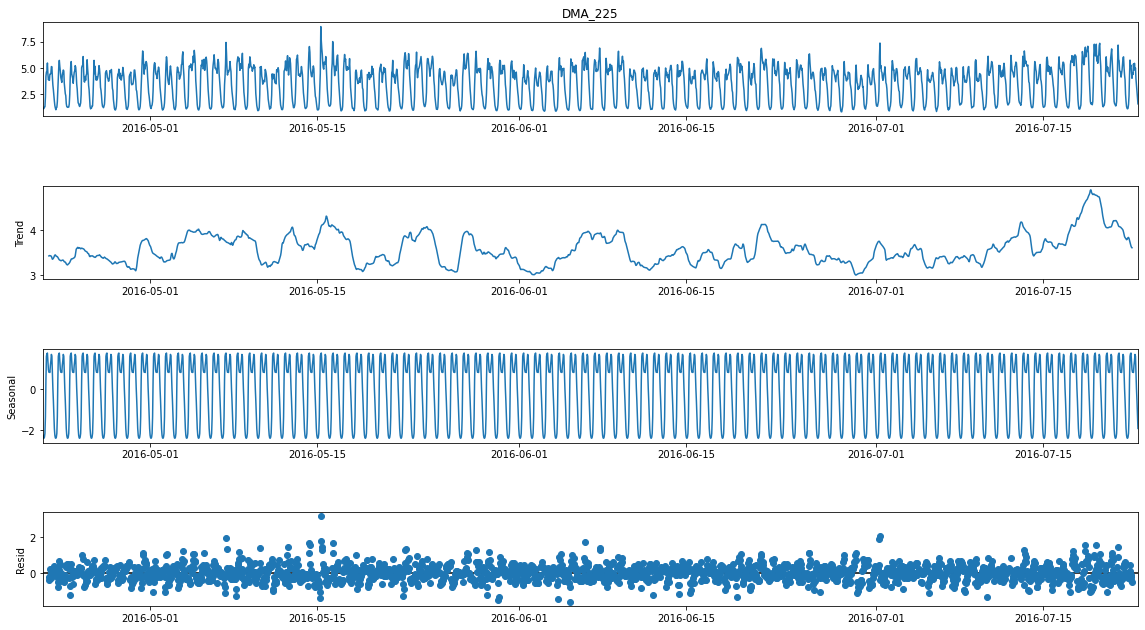

In [10]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(hourly_data.DMA_225,period=24)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

# Baseline model 

In [11]:
,'tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity'

"'tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity'"

In [12]:
# Making a df
Original = hourly_data["DMA_225",'tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity'].to_frame().rename(columns = {"DMA_225": "O_DMA_225","tempC":"O_tempC","HeatIndexC":"O_HeatIndexC","FeelsLikeC":"O_FeelsLikeC","WindChillC":"O_WindChillC","windspeedKmph":"O_windspeedKmph","sunHour":"O_sunHour","precipMM":"O_precipMM","humidity":"O_humidity"})
Forecast  = final_df1["DMA_225",'tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity'].to_frame().shift(1).rename(columns = {"DMA_225": "F_DMA_225","tempC":"F_tempC","HeatIndexC":"F_HeatIndexC","FeelsLikeC":"F_FeelsLikeC","WindChillC":"F_WindChillC","windspeedKmph":"F_windspeedKmph","sunHour":"F_sunHour","precipMM":"F_precipMM","humidity":"F_humidity" })
baseline = pd.concat([Original,Forecast],axis=1)
final = baseline[1:]#there is no prediction for first row due to shifting.
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(final.Original, final.Forecast))
rmse = round(rmse, 3)
print (" The root mean square value on dataset: ",rmse)

KeyError: ignored

# LSTM

In [13]:
hourly_data.shape

(2208, 9)

In [19]:
train_size = int(len(hourly_data)*0.6)
remaining_data = len(hourly_data) - train_size
# With the remaining data 70% is considered for validation set and 30% for test set.
validation_data = int((remaining_data)*0.7)
testing_data = remaining_data-validation_data
valid_size = (train_size)+(validation_data)
#valid_size = int(len(final_hourlydata)*0.9)

In [20]:
# # Split train data and test data
# train_size = int(len(hourly_data)*0.60)

# #train_data = df.WC.loc[:train_size] -----> it gives a series
# # Do not forget use iloc to select a number of rows
train_data = hourly_data.iloc[:train_size]
valid_data= hourly_data.iloc[train_size:valid_size]
test_data = hourly_data.iloc[valid_size:]

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
valid_scaled=scaler.fit_transform(valid_data)
test_scaled = scaler.fit_transform(test_data)

In [22]:
train_scaled.shape

(1324, 9)

In [24]:
valid_scaled.shape

(618, 9)

In [23]:
test_scaled.shape

(266, 9)

In [29]:
def data_preparation(array_dataset, look_back=1, future=1, index=0):
    features = array_dataset.shape[1]
    arr_X, arr_Y = [], []
    if len(array_dataset) - look_back <= 0:
        arr_X.append(array_dataset)
    else:
        for i in range(len(array_dataset) - look_back - future):
            arr_Y.append(array_dataset[(i + look_back):(i + look_back + future), index])
            arr_X.append(array_dataset[i:(i + look_back)])
    arr_X, arr_Y = np.array(arr_X), np.array(arr_Y)
    arr_X = np.reshape(arr_X, (arr_X.shape[0], look_back, features))
    return arr_X, arr_Y

look_back = 12
features = 9
X_train, Y_train = data_preparation(train_scaled, look_back=12, future=24, index=0)
X_valid,Y_valid = data_preparation(valid_scaled, look_back=12, future=24, index=0)
X_test, Y_test = data_preparation(test_scaled, look_back=12, future=24, index=0)

In [30]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],features))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1],features))
X_test = X_test.reshape( (X_test.shape[0],X_test.shape[1],features))

In [31]:
print('X_train shape:',X_train.shape)
print('Y_train shape:',Y_train.shape)
print('X_valid shape:',X_valid.shape)
print('Y_valid shape:',Y_valid.shape)
print('X_test shape:',X_test.shape)
print('Y_test shape:',Y_test.shape)

X_train shape: (1288, 12, 9)
Y_train shape: (1288, 24)
X_valid shape: (582, 12, 9)
Y_valid shape: (582, 24)
X_test shape: (230, 12, 9)
Y_test shape: (230, 24)


In [34]:
model = keras.models.Sequential([
keras.layers.LSTM(100,input_shape=(12,9)),
keras.layers.Dropout(0.4),
# keras.layers.Dense(30,kernel_initializer='normal'),

keras.layers.Dense(24)
])
#opt = keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss='mse', optimizer=opt),
model.compile(loss='mae', optimizer='adam'),
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train,Y_train,epochs = 50,validation_data=(X_valid,Y_valid),callbacks=[es_callback])

Epoch 1/50
41/41 [==============================] - 3s 25ms/step - loss: 0.2185 - val_loss: 0.1844
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1609 - val_loss: 0.1509
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1338 - val_loss: 0.1360
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1215 - val_loss: 0.1368
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1153 - val_loss: 0.1286
Epoch 6/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1099 - val_loss: 0.1229
Epoch 7/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1058 - val_loss: 0.1275
Epoch 8/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0996 - val_loss: 0.1208
Epoch 9/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0949 - val_loss: 0.1184
Epoch 10/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0903 - val_loss: 0.1073
Epoch 11/

In [225]:
model = keras.models.Sequential([
keras.layers.LSTM(70, input_shape=(12,9)),
keras.layers.Dropout(0.15),
keras.layers.Dense(40,kernel_initializer='normal'),
keras.layers.Dropout(0.37),
keras.layers.Dense(40,kernel_initializer='normal'),
keras.layers.Dropout(0.45),
keras.layers.Dense(24)
])
#opt = keras.optimizers.Adam(learning_rate=0.009)
#model.compile(loss='mse', optimizer=opt),
model.compile(loss='mae', optimizer='adam'),
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train,Y_train, batch_size = 40 ,epochs =45 ,validation_data=(X_valid,Y_valid),callbacks=[es_callback])

Epoch 1/45
33/33 [==============================] - 3s 26ms/step - loss: 0.2562 - val_loss: 0.2287
Epoch 2/45
33/33 [==============================] - 0s 12ms/step - loss: 0.2063 - val_loss: 0.2183
Epoch 3/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1847 - val_loss: 0.1667
Epoch 4/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1604 - val_loss: 0.1533
Epoch 5/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1465 - val_loss: 0.1373
Epoch 6/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1389 - val_loss: 0.1399
Epoch 7/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1317 - val_loss: 0.1390
Epoch 8/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1285 - val_loss: 0.1348
Epoch 9/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1250 - val_loss: 0.1317
Epoch 10/45
33/33 [==============================] - 0s 12ms/step - loss: 0.1217 - val_loss: 0.1280
Epoch 11/

In [226]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

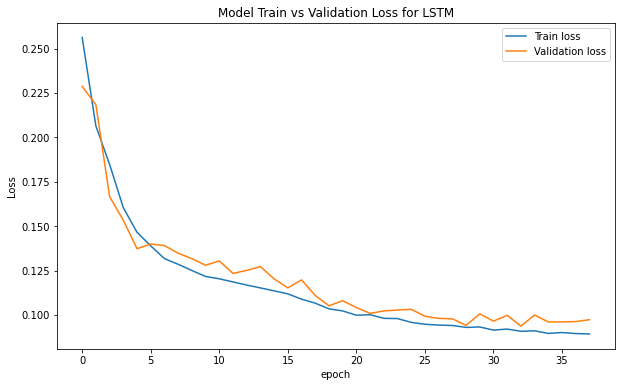

In [227]:
plot_loss(history,'LSTM')

In [220]:
# Generate predictions
train_pred = model.predict(X_train)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(X_test)
predictions = test_pred

In [221]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0]))
#final_df = pd.DataFrame((y_test[0]))
final_data = pd.DataFrame((Y_test))
final_data.rename(columns = {0:'original_value'}, inplace = True)
final_data['predicted_value'] = lstm_df

In [222]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_data['original_value'], final_data['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.1479974668893848


In [223]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(X_test)]
y = [y[0] for y in Y_test]
df_r = hourly_data.reset_index()
days = df_r['Date_time'].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_data], axis=1, join='inner')
result.shape


(230, 26)

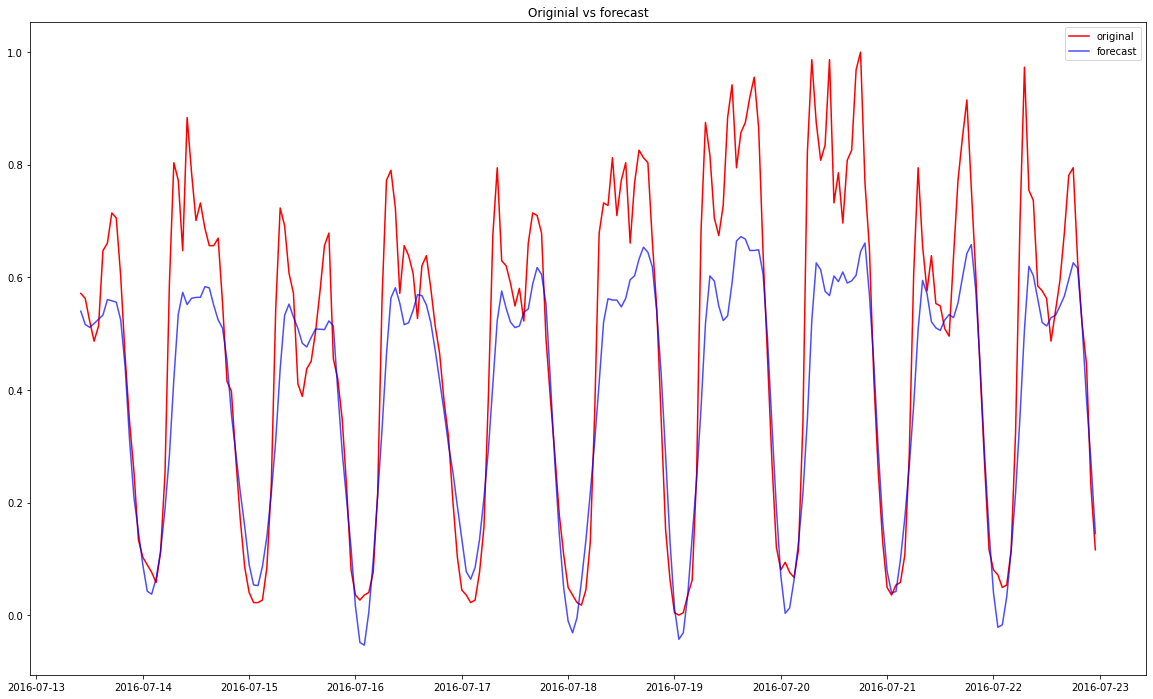

In [224]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [228]:
df.to_csv('raw_data.csv', index=False)
df.to_excel('raw_data.xls', index=False)

In [229]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_255_MLSTM_hp.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_255_MLSTM_hp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>